In [1]:
import iris
import matplotlib.pyplot as plt
import iris.quickplot as qplt
import iris.plot as iplt
import cartopy
import cartopy.crs as ccrs
import numpy as np
from windspharm.iris import VectorWind
from scipy.ndimage import gaussian_filter
iris.FUTURE.netcdf_promote = True
import iris.coords
g = iris.coords.AuxCoord(9.81,
                          long_name='gravitational_acceleration',
                          units='m s**-2')
t_step = 3
p_range=range(900,1100,4)
map_area=[-50, 20, 35, 75]

/Users/steve/anaconda/envs/grib/lib/python2.7/site-packages/iris/__init__.py:237: IrisDeprecation: setting the 'Future' property 'netcdf_promote' is deprecated and will be removed in a future release. Please remove code that sets this property.
  warn_deprecated(msg.format(name))


In [ ]:
lat_con = iris.Constraint(latitude=lambda cell: 25 < cell)
#c=iris.load(('27a.nc', '27b.nc', '27c.nc'))
c=iris.load(('871.nc', '872.nc', '873.nc'))
#cube = cube.intersection(longitude=(-100, 20))

In [ ]:
h=c.extract('geopotential')[0]

h300=h.extract(iris.Constraint(pressure_level=lambda cell: cell==300))
h500=h.extract(iris.Constraint(pressure_level=lambda cell: cell==500))
h1000=h.extract(iris.Constraint(pressure_level=lambda cell: cell==1000))
h500 /= g
h500.rename('geopotential_height')
h1000 /= g
h1000.rename('geopotential_height')
h300 /= g
h300.rename('geopotential_height')
tt=h500-h1000
tt.rename('thickness')

#pv=c.extract('Potential temperature')[0][t_step]
#pv.data = gaussian_filter(pv.data, sigma=1)

pv = c.extract('Potential vorticity')[0]
pv.convert_units('PVU')
#wv=c.extract('lwe_thickness_of_atmosphere_mass_content_of_water_vapor')[0]
wv=c.extract('Vertical integral of water vapour')[0]
mslp=c.extract('air_pressure_at_sea_level')[0]
mslp.convert_units('hPa')

In [ ]:
u=c.extract('eastward_wind')[0]
v=c.extract('northward_wind')[0]
t=c.extract('air_temperature')[0]
t.convert_units('Celsius')
t300=t.extract(iris.Constraint(pressure_level=lambda cell: cell==300))
t500=t.extract(iris.Constraint(pressure_level=lambda cell: cell==500))
t850=t.extract(iris.Constraint(pressure_level=lambda cell: cell==850))




In [ ]:
u300=u.extract(iris.Constraint(pressure_level=lambda cell: cell==300))
u500=u.extract(iris.Constraint(pressure_level=lambda cell: cell==500))
u1000=u.extract(iris.Constraint(pressure_level=lambda cell: cell==1000))
v300=v.extract(iris.Constraint(pressure_level=lambda cell: cell==300))
v500=v.extract(iris.Constraint(pressure_level=lambda cell: cell==500))
v1000=v.extract(iris.Constraint(pressure_level=lambda cell: cell==1000))
w = VectorWind(u300, v300)
ws300=w.magnitude()
iu300,iv300=w.irrotationalcomponent()
rv300=w.vorticity()
nu300,nv300=w.nondivergentcomponent()
vp=w.velocitypotential()
sf=w.streamfunction()
w500=VectorWind(u500,v500)
nu500,nv500=w.nondivergentcomponent()


ug=nu500
vg=nv500
#t300
dtdx,dtdy=w.gradient(t500)
dugdx,dugdy=w.gradient(ug)
dvgdx,dvgdy=w.gradient(vg)
a=dugdx*dtdx
b=dvgdx*dtdy
c=dugdy*dtdx
d=dvgdx*dtdy
Q1=a+b
Q2=c+d
Q1*=-10**8
Q2*=-10**8
qq=VectorWind(Q1,Q2)
qd=qq.divergence()
qd.data=gaussian_filter(qd.data, 1)



In [ ]:
thin=4
for t_step in range(0,7):
    x = u300.coord('longitude').points[::thin]
    y = u300.coord('latitude').points[::thin]
    uu = iu300[t_step].data[(slice(None,None,thin),slice(None,None,thin))]
    vv = iv300[t_step].data[(slice(None,None,thin),slice(None,None,thin))]

    plt.figure(figsize=((12,10)))
    ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-20))
    ax.set_extent(map_area, crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

    iplt.contourf(wv[t_step], range(15,75,5), cmap='YlGn')
    iplt.contourf(ws300[t_step], range(40,100,5), cmap='cool')
    qplt.contour(pv[t_step], range(1,10), colors='gray')
    plt.quiver(x, y, uu, vv, pivot='middle', transform=ccrs.PlateCarree())

    ax.gridlines()
    ax.coastlines()

    plt.show()


In [ ]:
thin=3
t_step=3
x = u300[t_step].coord('longitude').points[::thin]
y = u300[t_step].coord('latitude').points[::thin]
qu = Q1[t_step].data[(slice(None,None,thin),slice(None,None,thin))]
qv = Q2[t_step].data[(slice(None,None,thin),slice(None,None,thin))]
plt.figure(figsize=((12,10)))
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-20))
ax.set_extent(map_area, crs=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
#iplt.pcolormesh(pv[t_step])
qplt.contour(mslp[t_step], p_range, colors='k')
qplt.contourf(qd[t_step]*100000, cmap='RdBu_r', vmin=-0.3, vmax=0.3)
qplt.contour(t850[t_step])
plt.quiver(x, y, qu, qv, pivot='middle', transform=ccrs.PlateCarree())

ax.gridlines()
ax.coastlines()

plt.show()



In [ ]:
##### thin=2
for t_step in range(2,4):
    plt.figure(figsize=((12,10)))
    ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-20))
    ax.set_extent(map_area, crs=ccrs.PlateCarree())
    qplt.contourf(rv300[t_step], np.linspace(-0.0004,0.0004,16), cmap='RdBu_r', vmin=-0.0003, vmax=0.0003)
    qplt.contour(h300[t_step], range(-1000,10000,80), colors='r')
    #qplt.contour(w.streamfunction(), 20)
    #qplt.contour(vp, 20)
    #qplt.contour(mslp, p_range, colors='k')
    #qplt.contour(t, range(4980, 5940, 60), cmap='YlOrRd')
    #plt.quiver(x, y, uu, vv, pivot='middle', transform=ccrs.PlateCarree())
    #plt.quiver(x, y, uu, vv, pivot='middle', color='r', transform=ccrs.PlateCarree())

    ax.gridlines()
    ax.coastlines('50m')

    #plt.savefig('rv' + str(t_step) + '.png')
    plt.show()

In [ ]:
qplt.pcolormesh(qq.divergence()[0]*100000, cmap='RdBu_r', vmin=-0.3, vmax=0.3)
plt.show()

In [ ]:
ax=plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-80, 20, 30, 70], crs=ccrs.PlateCarree())
iplt.pcolormesh(pva[2], cmap='Blues', vmin=0)
iplt.contourf(ta850[2], range(3,19,2), cmap='Reds')
#iplt.contour(t850[3], colors='g')
ax.coastlines()
ax.gridlines()
plt.colorbar()
plt.show()

In [ ]:
hm300 = h300.collapsed('longitude', iris.analysis.MEAN)
ha300 = h300 - hm300
tm850 = t850.collapsed('longitude', iris.analysis.MEAN)
ta850 = t850 - tm850
pvm = pv.collapsed('longitude', iris.analysis.MEAN)
pva = pv - pvm

In [ ]:
iplt.plot(pvm[4])
plt.show()

In [ ]:
hm300[0].data

In [2]:
wv = iris.load('wv.nc')

In [14]:
print(wv)
u=wv[0]
v=wv[1]
w = VectorWind(u,v)

0: Vertical integral of eastward water vapour flux / (kg m**-1 s**-1) (time: 1; latitude: 361; longitude: 720)
1: Vertical integral of northward water vapour flux / (kg m**-1 s**-1) (time: 1; latitude: 361; longitude: 720)


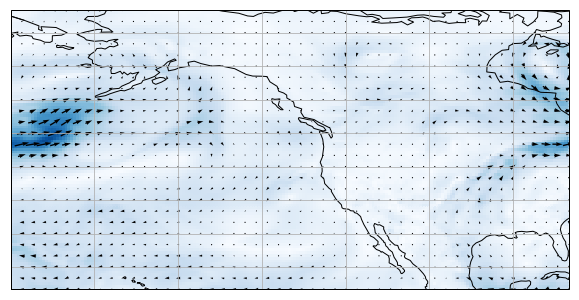

In [31]:
plt.figure(figsize=(10,8))
ax=plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, -80, 20, 70], crs=ccrs.PlateCarree())
iplt.pcolormesh(w.magnitude()[0], cmap='Blues')
plt.quiver(x, y, uu, vv, pivot='middle', transform=ccrs.PlateCarree())


ax.coastlines()
ax.gridlines()
#plt.colorbar()
plt.show()



In [23]:
thin=4
t_step=0
x = u[t_step].coord('longitude').points[::thin]
y = u[t_step].coord('latitude').points[::thin]
uu = u[t_step].data[(slice(None,None,thin),slice(None,None,thin))]
vv = v[t_step].data[(slice(None,None,thin),slice(None,None,thin))]